# Algo

Takes total sleep duration in minutes (calculated as: stop time – start time).

Takes start time (from when user pressed Start Recording).

Generates a timeline of sleep stages (Awake → Light → Deep → REM → back to Awake).

Saves results into a JSON file (list of {time, stage} objects).

----------

Inputs needed from app:

start_time → the timestamp when user pressed Start Recording

stop_time → the timestamp when user pressed Stop Recording

From these, compute total_minutes = stop_time - start_time.

Example: Start at 23:30, Stop at 07:30 → 480 minutes





In [ ]:
import datetime
import json
import random
import os

def simulate_sleep_cycle(total_minutes: int, start_time: str = "00:00"):

    stages = ["Awake", "Light", "Deep", "REM"]
    timeline = []

    start_dt = datetime.datetime.strptime(start_time, "%H:%M")

    # awake at beginning
    awake_duration = min(30, total_minutes // 6)  # adaptive awake time
    for m in range(awake_duration):
        timeline.append({
            "time": (start_dt + datetime.timedelta(minutes=m)).strftime("%H:%M"),
            "stage": "Awake"
        })

    current_time = start_dt + datetime.timedelta(minutes=awake_duration)
    minutes_left = total_minutes - awake_duration * 2  # save last awake period

    #  ensure we always have at least some minutes for cycles 
    if minutes_left < 15:  # too short for full cycle
        minutes_left = max(5, total_minutes - awake_duration)  

    while minutes_left > 0:
        # light sleep
        light_duration = min(random.randint(20, 40), minutes_left)
        for m in range(light_duration):
            timeline.append({
                "time": (current_time + datetime.timedelta(minutes=m)).strftime("%H:%M"),
                "stage": "Light"
            })
        minutes_left -= light_duration
        current_time += datetime.timedelta(minutes=light_duration)

        if minutes_left <= 0: break

        # deep sleep
        deep_duration = min(random.randint(20, 60), minutes_left)
        for m in range(deep_duration):
            timeline.append({
                "time": (current_time + datetime.timedelta(minutes=m)).strftime("%H:%M"),
                "stage": "Deep"
            })
        minutes_left -= deep_duration
        current_time += datetime.timedelta(minutes=deep_duration)

        if minutes_left <= 0: break

        # REM sleep
        rem_duration = min(random.randint(10, 30), minutes_left)
        for m in range(rem_duration):
            timeline.append({
                "time": (current_time + datetime.timedelta(minutes=m)).strftime("%H:%M"),
                "stage": "REM"
            })
        minutes_left -= rem_duration
        current_time += datetime.timedelta(minutes=rem_duration)

    # awake at end
    for m in range(awake_duration):
        timeline.append({
            "time": (current_time + datetime.timedelta(minutes=m)).strftime("%H:%M"),
            "stage": "Awake"
        })

    return timeline


def save_sleep_json(total_minutes, start_time="00:00", filename="sleep_data.json"):
    """Run simulation and save results to a JSON file"""
    timeline = simulate_sleep_cycle(total_minutes, start_time)
    with open(filename, "w") as f:
        json.dump(timeline, f, indent=2)
    print(f"✅ JSON saved to: {os.path.abspath(filename)}")
    return timeline


# Example usage:
if __name__ == "__main__":
    total_minutes = 480   # <--  CHANGE THIS for different total sleep durations
    start_time = "23:30"  # <--  CHANGE THIS for different sleep start times
    filename = "sleep_data.json"  # <--  CHANGE this to save under a new name

    timeline = save_sleep_json(total_minutes, start_time, filename)
    print(f"Generated {len(timeline)} entries, from {timeline[0]['time']} to {timeline[-1]['time']}")


✅ JSON saved to: c:\Users\mohsn\Code\sleep_analysis\sleep_data.json
Generated 480 entries, from 23:30 to 07:29


The function should return a JSON array of objects.

Each object contains:

"time" → timestamp in HH:MM

"stage" → "Awake" | "Light" | "Deep" | "REM"

## Behavioral rules

Always Awake for ~first and last 30 min (or proportionally shorter if total sleep < 2 hours).

Cycles should flow biologically:

Awake → Light → Deep → REM → Light → … repeat

Never jumps from REM straight to Awake.

Short sleep adapts:

If only 30 min → first 10 Awake, last 10 Awake, middle = Light.

Night vs Day variation:

If user sleeps at night, deeper cycles in middle.

If user naps in daytime, cycles should be lighter/shorter.

# Example test code (With a plotted graph)

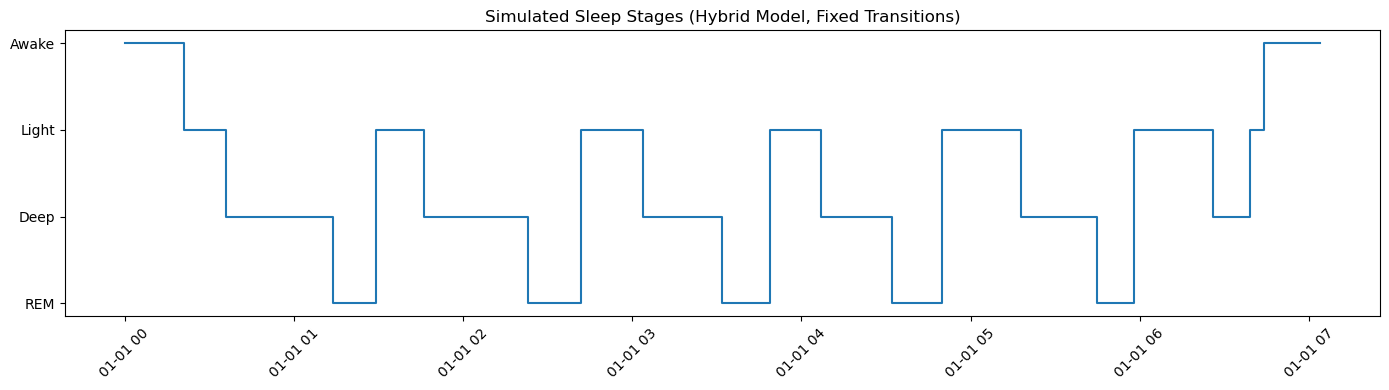

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def simulate_sleep_stages(start_time="00:00", duration_minutes=480):

    stages = ["Awake", "Light", "Deep", "REM"]
    stage_to_num = {s: i for i, s in enumerate(stages)}

    # Timeline
    stages_timeline = []

    # Awake at start (5–15 mins depending on night length)
    awake_start = max(5, int(0.05 * duration_minutes))
    stages_timeline.extend(["Awake"] * awake_start)

    # Special case for naps (< 60 mins total)
    if duration_minutes < 60:
        mid_sleep = duration_minutes - 2 * awake_start
        if mid_sleep > 0:
            stages_timeline.extend(["Light"] * mid_sleep)
        stages_timeline.extend(["Awake"] * awake_start)
        return stages_timeline, stage_to_num

    # Sleep cycles
    remaining = duration_minutes - 2 * awake_start
    while remaining > 0:
        # Light → Deep → REM → Light cycle
        light = np.random.randint(10, 20)
        deep = np.random.randint(20, 40)
        rem = np.random.randint(10, 20)
        light2 = np.random.randint(5, 15)

        cycle = (["Light"] * light +
                 ["Deep"] * deep +
                 ["REM"] * rem +
                 ["Light"] * light2)

        if len(cycle) > remaining:
            cycle = cycle[:remaining]

        stages_timeline.extend(cycle)
        remaining -= len(cycle)

    # Awake at end
    last_stage = stages_timeline[-1]
    if last_stage == "REM":
        stages_timeline.extend(["Light"] * 10)  # transition
    elif last_stage == "Deep":
        stages_timeline.extend(["Light"] * 5)   # transition
    stages_timeline.extend(["Awake"] * awake_start)

    return stages_timeline, stage_to_num

def plot_sleep(stages_timeline, stage_to_num, start_time="00:00"):
    times = []
    values = []
    start_dt = datetime.datetime.strptime(start_time, "%H:%M")
    for i, stage in enumerate(stages_timeline):
        times.append(start_dt + datetime.timedelta(minutes=i))
        values.append(stage_to_num[stage])

    plt.figure(figsize=(14, 4))
    plt.step(times, values, where="post")

    plt.yticks(list(stage_to_num.values()), list(stage_to_num.keys()))
    plt.gca().invert_yaxis()  # Awake on top
    plt.title("Simulated Sleep Stages (Hybrid Model, Fixed Transitions)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example run
timeline, mapping = simulate_sleep_stages("00:00", duration_minutes=420)
plot_sleep(timeline, mapping, "00:00")
